# Recap of the Key Concepts (lessons 2-3)

Key concepts we learnt up to now: 

1. State, Nodes and Edges are the key components of our graph. **State is shared by all nodes and can be accessed at any time**;

2. State is a just a `TypedDict`. We can (and should) leverage pre-built states like `MessagesState` and `AgentState` anytime possible, by inheriting from this classes in our custom state.

    We use `MessagesState` when we just need to keep track of messages, i.e., usually when we work with "vanilla" llms (no tools); we use `AgentState` for more complex graphs - usually when we want to work with agents, using tools.

3. **(!)** Nodes return **state updates**;

4. We use `create_agent()` to create an agent that runs in a loop using its tools. 

---

## Exercises Solutions 

### Ex. 2.1 : Create a graph that greets the user, given its name

In [9]:
from typing import TypedDict

class MyState(TypedDict):
    user_name: str   
    message : str

In [10]:
def greeting_node(state):
    print("***executing greeting node")

    return {"message": "Hello " + state['user_name'] + ", how are you today?"}

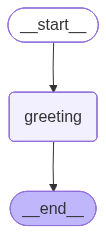

In [11]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

builder = StateGraph(MyState)

builder.add_node("greeting", greeting_node)
builder.add_edge(START, "greeting")
builder.add_edge("greeting", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
init_state = {"user_name" : "Matteo"}

graph.invoke(init_state)

***executing greeting node


{'user_name': 'Matteo', 'message': 'Hello Matteo, how are you today?'}

### Ex. 3.1: Create a graph that leverages an llm, with two tools of your choice

I'll create a tool to search online using `Tavily` and a tool to write a report.

#### Tools

In [ ]:
from langchain.tools import tool
from langchain_community.tools import TavilySearchResults  # actually deprecated
from dotenv import load_dotenv

# needs Tavily API key
load_dotenv()

# Define search tool
search_tool = TavilySearchResults(
  max_results=5,
  include_raw_content=True,
)

@tool
def write_report(title : str, content : str):
    """
    Use this to write a report. Do not include the title in the content.
    """

    with open("./report.txt", "w") as f:
        f.write(title + "\n")
        f.write(content)
    
    return "Report written successfully"

#### Agent

In [28]:
prompt="""
You are a helpful assistant that can search the web and write reports.


## Tools

You have access to the following tools:
- search_tool(query: str) -> str: to search the web given a query
- write_report(title: str, content: str) -> str: to write a report, given a title and content. Do not include the title in the content.


## Notes 

- NEVER include the title in the content of the report when using the write_report tool.
- Look up topics online with your search_tool anytime possible. 
- If asked to write a report on some topic. first look up info online with your search_tool, then write the report with the write_report tool
"""

In [29]:
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI

agent = create_agent(
    model=ChatOpenAI(model="gpt-4o-mini", temperature=0),
    tools=[search_tool, write_report],
    system_prompt=prompt
)

In [36]:
from langchain_core.messages import HumanMessage

init_state = {"messages" : HumanMessage(content="Write a report on inflation in the 21st century in Argentina. Make it short and concise.")}

chunks = []

for chunk in agent.stream(init_state):
    chunks.append(chunk)
    
    for node_name, values in chunk.items():
        if 'messages' in values:
            values['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_KmHZGNUK6gjVxMruezJvxoxj)
 Call ID: call_KmHZGNUK6gjVxMruezJvxoxj
  Args:
    query: inflation in Argentina 21st century
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Argentina - Economy, Politics, Culture", "url": "https://www.britannica.com/place/Argentina/Argentina-in-the-21st-century", "content": "For the most part, the Argentine economy rebounded robustly over much of the first decade of the 21st century, but it continued to be plagued by among the highest inflation rates in the Western Hemisphere. Government-imposed price and export controls proved largely ineffective in constraining inflation, which, according to official figures, reached 10.6 percent in 2012, though many foreign and domestic observers believed it to actually be considerably higher, with some estimating it 

In [37]:
for chunk in chunks:
    print(chunk)

{'model': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 276, 'total_tokens': 301, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_aa07c96156', 'id': 'chatcmpl-CkpRfsuthmBvp6F0QeMGV4KIywLDl', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--75c6cf8d-f66c-46cf-a93a-d9d66c5157e2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'inflation in Argentina 21st century'}, 'id': 'call_KmHZGNUK6gjVxMruezJvxoxj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 276, 'output_tokens': 25, 'total_tokens': 301, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_detai